In [1]:
import numpy as np
import json
import cvxpy as cp
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

from src.problems.utils import sample_data_for_group
from src.problems.problems import (
    _compute_consumer_optimal_solution_cvar,
    _compute_consumer_optimal_solution_mean,
    _compute_consumer_optimal_solution_min
)

In [2]:
sns.set_style("whitegrid")
mpl.rc('font', **{'size': 14})
plt.rcParams["font.family"] = "Times New Roman"

In [3]:
DATA_PATH_ROOT = Path("../../data")

In [4]:
# load data
with open(DATA_PATH_ROOT / "simrec_predictions.npy", "rb") as f:
    REL_MATRIX = np.load(f)

with open(DATA_PATH_ROOT / "simrec_user_groups.json", "r") as f:
    GROUPS_MAP = json.load(f)

In [5]:
N_CONSUMERS = 500
N_PRODUCERS = 500
GROUP_KEY = "top_category"
K_REC = 10
SOLVER = cp.GUROBI
GAMMA = 0.5
ALPHA = 0.95

In [6]:
rel_matrix_sampled, consumer_ids, group_assignments = sample_data_for_group(
    n_consumers=N_CONSUMERS,
    n_producers=N_PRODUCERS,
    groups_map=GROUPS_MAP,
    group_key=GROUP_KEY,
    data=REL_MATRIX,
    naive_sampling=True,
    seed=0,
)

In [7]:
min_allocations = _compute_consumer_optimal_solution_min(
    rel_matrix=rel_matrix_sampled,
    k_rec=K_REC,
    producer_max_min_utility=10,
    gamma=GAMMA,
    solver=SOLVER
)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2653936
Academic license 2653936 - for non-commercial use only - registered to do___@student.uva.nl

Interrupt request received


/Users/dominykas.seputis/github/msc-thesis/.venv/lib/python3.12/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [8]:
mean_allocations = _compute_consumer_optimal_solution_mean(
    rel_matrix=rel_matrix_sampled,
    k_rec=K_REC,
    producer_max_min_utility=10,
    gamma=GAMMA,
    solver=SOLVER
)

In [9]:
cvar_allocations =_compute_consumer_optimal_solution_cvar(
    rel_matrix=rel_matrix_sampled,
    k_rec=K_REC,
    producer_max_min_utility=10,
    gamma=GAMMA,
    group_assignments=group_assignments,
    alpha=ALPHA,
    solver=SOLVER
)

In [10]:
# compute correlation
np.corrcoef(cvar_allocations[1].flatten(), mean_allocations[1].flatten())

array([[1.        , 0.83979592],
       [0.83979592, 1.        ]])

In [11]:
top_k_greedy = rel_matrix_sampled.argsort(axis=1)[:, -K_REC:]
greedy_allocations = rel_matrix_sampled[np.arange(rel_matrix_sampled.shape[0])[:, None], top_k_greedy]

In [12]:
(mean_allocations[1] * rel_matrix_sampled).sum(axis=1)  / greedy_allocations.sum(axis=1)

array([0.9722648 , 0.84240887, 0.88441449, 0.75382594, 0.83346948,
       0.86156197, 0.68601982, 0.64508558, 0.79760137, 0.6847946 ,
       0.87764758, 0.71738399, 0.77773788, 0.68303825, 0.71636821,
       0.72003417, 0.65703694, 0.83073376, 0.76867712, 0.74575702,
       0.66191602, 0.61258797, 0.72761068, 0.76887842, 0.65736552,
       0.79947355, 0.88627223, 0.6957639 , 0.62655866, 0.96812817,
       0.72683386, 0.84295127, 0.76519283, 0.97947424, 0.69370959,
       0.76536847, 0.80651961, 0.79620376, 0.82046278, 0.6835959 ,
       0.53551043, 0.76545732, 0.9316394 , 0.76262364, 0.74453226,
       0.69336863, 0.86828856, 0.66418633, 0.77495491, 0.69822955,
       0.73284255, 0.61300284, 0.65287266, 0.9672841 , 0.64683277,
       0.76585816, 0.7525927 , 0.84088946, 0.80356908, 0.58972   ,
       0.97720277, 0.90351483, 0.67636898, 0.63876196, 0.68959555,
       0.61596989, 0.90677943, 0.69267044, 0.78352416, 0.71530898,
       0.81582383, 0.85286504, 0.74081956, 0.8625579 , 0.79708

In [13]:
min_vals = min_allocations[1] * rel_matrix_sampled
mean_vals = mean_allocations[1] * rel_matrix_sampled
cvar_vals = cvar_allocations[1] * rel_matrix_sampled
min_vals = min_vals.sum(axis=1) / greedy_allocations.sum(axis=1)
mean_vals = mean_vals.sum(axis=1) / greedy_allocations.sum(axis=1)
cvar_vals = cvar_vals.sum(axis=1) / greedy_allocations.sum(axis=1)

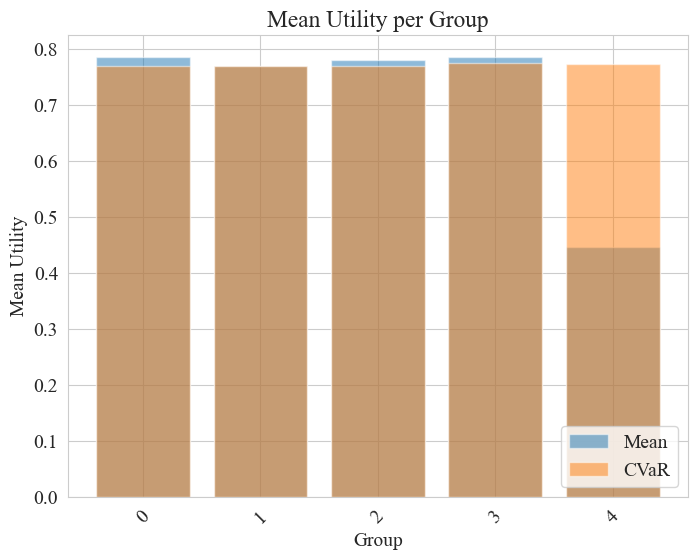

In [14]:
mean_vals_per_group = {}
for group in set(group_assignments):
    mean_vals_per_group[group] = mean_vals[group_assignments == group].mean()

plt.figure(figsize=(8, 6))
plt.title("Mean Utility per Group")
plt.xlabel("Group")
plt.ylabel("Mean Utility")
plt.xticks(rotation=45)
plt.bar(mean_vals_per_group.keys(), mean_vals_per_group.values(), label="Mean", alpha=0.5)

mean_vals_per_group = {}
for group in set(group_assignments):
    mean_vals_per_group[group] = cvar_vals[group_assignments == group].mean()

plt.bar(mean_vals_per_group.keys(), mean_vals_per_group.values(), label="CVaR", alpha=0.5)
plt.legend(loc="lower right")


In [15]:
sns.set_style("white")
mpl.rc('font', **{'size': 14})
plt.rcParams["font.family"] = "Times New Roman"
sns.set_palette("tab10")

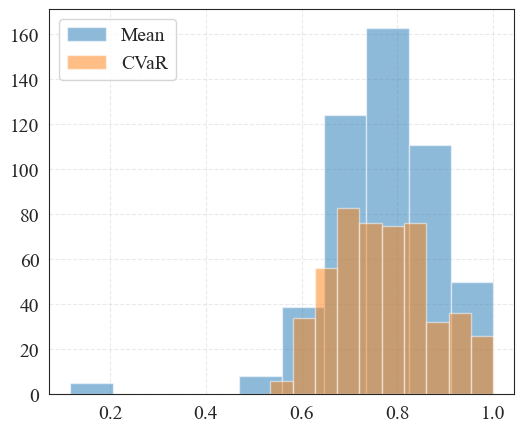

In [16]:
fig, ax = plt.subplots(figsize=(6, 5))
plt.grid(True, linestyle="--", alpha=0.4)
plt.hist(mean_vals, bins=10, alpha=0.5, label="Mean", density=False)
plt.hist(cvar_vals, bins=10, alpha=0.5, label="CVaR", density=False)
#ax.set_yscale('log')
plt.legend()

In [17]:
rel_matrix_sampled

array([[0.14136478, 0.25235665, 0.8643186 , ..., 0.21613188, 0.27130732,
        0.99873024],
       [0.14073606, 0.2537272 , 0.8642438 , ..., 0.21563466, 0.27206996,
        0.99650216],
       [0.14038816, 0.25360373, 0.86335915, ..., 0.21614967, 0.27111855,
        0.9982532 ],
       ...,
       [0.11676946, 0.16587323, 0.66469264, ..., 0.14973545, 0.17419238,
        0.9810993 ],
       [0.10604095, 0.1271143 , 0.35596168, ..., 0.12055673, 0.13064224,
        0.7792211 ],
       [0.10529602, 0.12744884, 0.35482   , ..., 0.12012885, 0.13066569,
        0.7755021 ]], shape=(500, 500), dtype=float32)